# Making digits with PCA and KDE without any libraries

## PCA on the digits

In [32]:
from sklearn.datasets import load_digits
import numpy as np
from numpy import mean
from numpy import cov
from numpy.linalg import eig
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

sns.set(color_codes=True)
plt.style.use('ggplot')

In [33]:
#load digits and pick however many
digits = load_digits()
A=digits.data[0:64]

In [34]:
#mean of columns
M = mean(A, axis=0)
#center matrix
C = (A - M)
#covariance matrix
V=np.cov(C.T)
# eigenvectors and values
values, vectors = eig(V)

def myPCA(N):       
    '''Returns the eigenvectors and PC used and not used
        N=desired number of components
    '''
    #sort eigenvalues by descending order
    max_values=np.flip(np.sort(values))
    eigenvectors = np.zeros((np.shape(C)[1],N))
    eigenvectors_not = np.zeros((np.shape(C)[1],np.shape(C)[1]-N))
    
    #make eigenvectors corresponding to N largest eigenvalues
    for i in range(N):       
        max_eig=np.where(values == max_values[i])[0]     
        eigenvectors[:,i]=vectors[:,max_eig][:,0]
        
    #make the rest of the eigenvectors    
    for i in range(np.shape(C)[1]-N):
        max_values=np.flip(max_values)
        min_eig=np.where(values == max_values[i])[0]
        eigenvectors_not[:,i]=vectors[:,min_eig][:,0]

    PC=C@eigenvectors 
    PC_not=C@eigenvectors_not
    
    return eigenvectors,PC,eigenvectors_not,PC_not

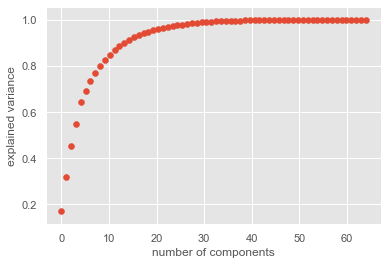

In [35]:
#calculate and plot explained variance as a function of number of components
explained_variance=np.zeros(np.shape(C)[1])
for i in range(np.shape(C)[1]):
    explained_variance[i]=np.sum(np.var(myPCA(i+1)[1],axis=0,ddof=1))/ np.sum(np.var(A,axis=0,ddof=1))

plt.ylabel('explained variance')
plt.xlabel('number of components')
plt.scatter(np.linspace(0,np.shape(C)[1],np.shape(C)[1]),explained_variance)

## KDE on PCA output

In [31]:
x_grid=np.linspace(-100,100,2000)

def PDF(X,sigma):
    #PC's are 1D so k=1
    k=1
    x_new = np.array([[x] for x in x_grid] + [[x] for x in X])
    #distance matrix
    d = squareform(pdist(x_new))   
    d = d[np.shape(x_grid)[0]:np.shape(x_new)[0],0:np.shape(x_grid)[0]] 
    #Gaussian kernel
    d = (2*np.pi)**(-k/2)*(sigma**(2*k))**(-1/2)* np.exp(-(d)**2/(2*sigma** 2))
    #divide by shape of X so intergral of pdf sums to 1
    pdf=np.sum(d,axis=0)/np.shape(X)[0]
    return pdf


Text(0, 0.5, 'Probability density')

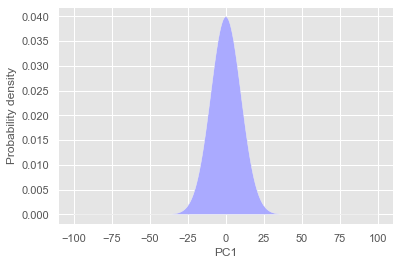

In [41]:
#visualise the pdf of PC1
#make PC1
PC1=myPCA(44)[0][0]
#get PDF of PC1 with sigma 10
PDF_PC1=PDF(PC1,10)
plt.fill(x_grid,PDF_PC1, fc='#AAAAFF')
plt.xlabel('PC1')
plt.ylabel('Probability density')

## Making the digits

In [79]:
def newDigits(n_components,n_sample):
    '''fetches every PC1 from myPCA of n_components, 
    applies KDE with PDF, converts back to original shape
    n_components=number of PCA components, n_sample=number of 
    new images to create'''
    
    sample=np.zeros((n_sample,n_components))
    for i in range(n_components):
        #get PC
        PC=myPCA(n_components)[1][:,i]
        #calculate optimal bandwidth
        sigma=1.06*np.std(PC)*np.shape(PC)[0]**(-1/5)
        #get PDF
        pdf=PDF(PC,sigma)
        #get probability distribution (sums to 1)
        p=(pdf/np.sum(pdf))
        #sample from PDF with probabibility distribution p
        samp=np.random.choice(np.arange(pdf.size),n_sample,p=p,replace=False)
        #find the corresponding x values
        samp=x_grid[samp]
        sample[:,i]=np.array(samp)

        
    #get n_components eigenvectors
    eigenvectors=myPCA(n_components)[0]
    #invert back to 64 dimensinos
    new_digits=sample.dot(eigenvectors.T)+mean(A,axis=0)
    new_digits=new_digits.reshape(n_sample,8,8)
    
    return new_digits

Text(0.5, 1.0, 'Generated digits')

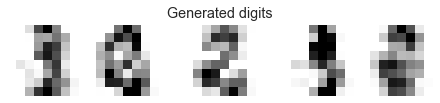

<Figure size 432x288 with 0 Axes>

In [88]:
#plot 5 new digits
new_digits=newDigits(44,5)
fig, ax = plt.subplots(1,np.shape(new_digits)[0], subplot_kw=dict(xticks=[], yticks=[]),constrained_layout=True)

for i in range(np.shape(new_digits)[0]):
    im = ax[i].imshow(new_digits[i,:,:], cmap=plt.cm.binary,interpolation='nearest')
    im.set_clim(0, 16)
plt.figure()
ax[2].set_title('Generated digits')
